In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import os

In [2]:
directory = 'cluster_probs'

# Initialize an empty list to store the dataframes
dataframes = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        # Read the CSV file into a DataFrame
        df = pd.read_csv(os.path.join(directory, filename))
        
        # Extract the prefix from the filename (before "_cluster_probs")
        prefix = filename.split("_cluster_probs")[0]
        
        # Rename the columns
        new_column_names = {
            '0': f'{prefix}_cluster0',
            '1': f'{prefix}_cluster1',
            '2': f'{prefix}_cluster2'
        }
        df.rename(columns=new_column_names, inplace=True)
        
        # Append the DataFrame to the list
        dataframes.append(df)

# Merge all the dataframes on the 'teamId' column
final_df = pd.concat(dataframes, axis=1)
final_df = final_df.loc[:,~final_df.columns.duplicated()]  # Remove duplicate columns if any, particularly 'teamId'
final_df.drop("Unnamed: 0", axis = 1, inplace = True)
team_ids = final_df['teamId']
final_df.set_index("teamId", inplace = True)

In [3]:
final_df

,in_poss_cluster0,in_poss_cluster1,in_poss_cluster2,out_of_poss_cluster0,out_of_poss_cluster1,out_of_poss_cluster2,trans_out_of_poss_cluster0,trans_out_of_poss_cluster1,trans_out_of_poss_cluster2,trans_poss_cluster0,trans_poss_cluster1,trans_poss_cluster2
teamId,,,,,,,,,,,,
674,0.421053,0.131579,0.447368,0.368421,0.289474,0.342105,0.526316,0.236842,0.236842,0.605263,0.052632,0.342105
675,0.868421,0.000000,0.131579,0.526316,0.473684,0.000000,0.526316,0.447368,0.026316,0.078947,0.000000,0.921053
676,0.868421,0.000000,0.131579,0.342105,0.631579,0.026316,0.605263,0.289474,0.105263,0.078947,0.000000,0.921053
677,0.210526,0.368421,0.421053,0.157895,0.473684,0.368421,0.473684,0.131579,0.394737,0.552632,0.263158,0.184211
678,0.105263,0.394737,0.500000,0.210526,0.315789,0.473684,0.368421,0.157895,0.473684,0.552632,0.368421,0.078947
...,...,...,...,...,...,...,...,...,...,...,...,...
3795,0.131579,0.394737,0.473684,0.210526,0.394737,0.394737,0.552632,0.289474,0.157895,0.710526,0.157895,0.131579
3799,0.184211,0.342105,0.473684,0.263158,0.447368,0.289474,0.447368,0.315789,0.236842,0.631579,0.236842,0.131579
3804,0.078947,0.263158,0.657895,0.263158,0.315789,0.421053,0.315789,0.315789,0.368421,0.657895,0.263158,0.078947


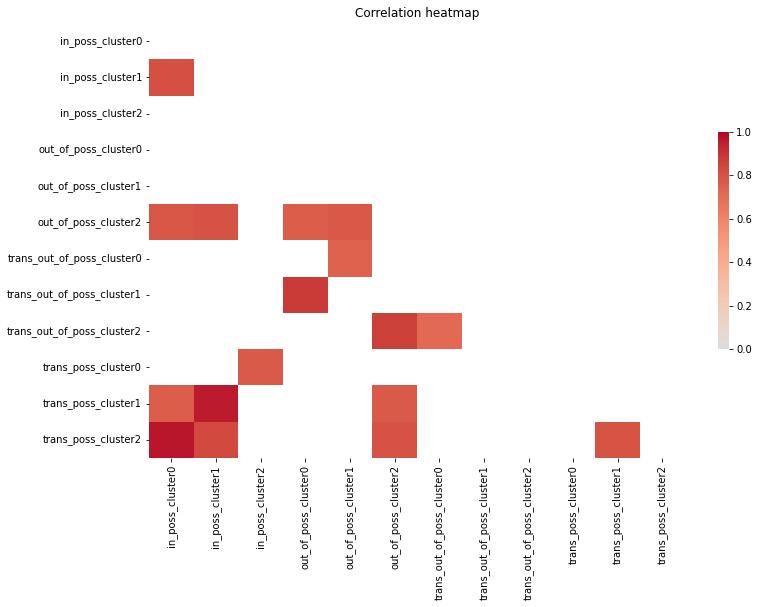

In [4]:
corr = final_df.corr().abs()
corr[corr.abs() < 0.7] = np.nan

plt.figure(figsize=(12, 8))
sns.heatmap(corr.abs(), cmap="coolwarm", 
            mask=np.triu(np.ones_like(corr.abs(), dtype=bool)),
            cbar_kws={"shrink": .5}, vmin=0, vmax=1, center= 0)
plt.title('Correlation heatmap')
plt.show()

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

# 1. Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_df)
# Note: PCA's n_components set to 0.9 means PCA will select the minimum number of components such that at least 90% of the variance is retained.

In [6]:
# 2. Apply PCA
pca = PCA(n_components=2) 
final_df_scaled = pca.fit_transform(scaled_data)

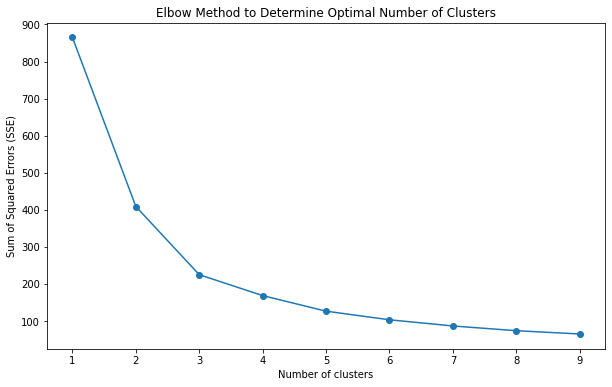

In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
k_range = range(1, 10) 
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(final_df_scaled)
    sse.append(kmeans.inertia_)

# Plotting the Elbow Graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method to Determine Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks(k_range)
plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, BisectingKMeans

k = 3

# Applying K-Means Clustering
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans_labels = kmeans.fit_predict(final_df_scaled)

# Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=k, random_state=0)  
gmm_clusters = gmm.fit_predict(final_df_scaled)

# Applying Bisecting K-Means Clustering
bkmeans = BisectingKMeans(n_clusters=k, random_state=0)
bkmeans_labels = bkmeans.fit_predict(final_df_scaled)

# Creating a DataFrame to see the cluster labels alongside team IDs
clustered_teams = pd.DataFrame({'TeamID': team_ids, 'KMeans_Labels': kmeans_labels, 'GMM_Labels': gmm_clusters, 'BKMeans_Labels': bkmeans_labels})

In [9]:
from sklearn.metrics import silhouette_score

# Calculating the average silhouette score for KMeans clustering
silhouette_avg_kmeans = silhouette_score(final_df_scaled, kmeans_labels)
print(f"Average Silhouette Score for KMeans Clustering: {silhouette_avg_kmeans:.3f}")

# Calculating the average silhouette score for Gaussian Mixture Model clustering
silhouette_avg_gmm = silhouette_score(final_df_scaled, gmm_clusters)
print(f"Average Silhouette Score for Gaussian Mixture Model Clustering: {silhouette_avg_gmm:.3f}")

# Calculating the average silhouette score for Hierarchical Clustering
silhouette_avg_hierarchical = silhouette_score(final_df_scaled, bkmeans_labels)
print(f"Average Silhouette Score for Hierarchical Clustering: {silhouette_avg_hierarchical:.3f}")

Average Silhouette Score for KMeans Clustering: 0.453
Average Silhouette Score for Gaussian Mixture Model Clustering: 0.427
Average Silhouette Score for Hierarchical Clustering: 0.425


In [10]:
final_df

,in_poss_cluster0,in_poss_cluster1,in_poss_cluster2,out_of_poss_cluster0,out_of_poss_cluster1,out_of_poss_cluster2,trans_out_of_poss_cluster0,trans_out_of_poss_cluster1,trans_out_of_poss_cluster2,trans_poss_cluster0,trans_poss_cluster1,trans_poss_cluster2
teamId,,,,,,,,,,,,
674,0.421053,0.131579,0.447368,0.368421,0.289474,0.342105,0.526316,0.236842,0.236842,0.605263,0.052632,0.342105
675,0.868421,0.000000,0.131579,0.526316,0.473684,0.000000,0.526316,0.447368,0.026316,0.078947,0.000000,0.921053
676,0.868421,0.000000,0.131579,0.342105,0.631579,0.026316,0.605263,0.289474,0.105263,0.078947,0.000000,0.921053
677,0.210526,0.368421,0.421053,0.157895,0.473684,0.368421,0.473684,0.131579,0.394737,0.552632,0.263158,0.184211
678,0.105263,0.394737,0.500000,0.210526,0.315789,0.473684,0.368421,0.157895,0.473684,0.552632,0.368421,0.078947
...,...,...,...,...,...,...,...,...,...,...,...,...
3795,0.131579,0.394737,0.473684,0.210526,0.394737,0.394737,0.552632,0.289474,0.157895,0.710526,0.157895,0.131579
3799,0.184211,0.342105,0.473684,0.263158,0.447368,0.289474,0.447368,0.315789,0.236842,0.631579,0.236842,0.131579
3804,0.078947,0.263158,0.657895,0.263158,0.315789,0.421053,0.315789,0.315789,0.368421,0.657895,0.263158,0.078947


In [11]:
k_clustered_teams = clustered_teams.drop(columns=['GMM_Labels', 'BKMeans_Labels'])
final_df.reset_index(inplace = True)
df_with_clusters = final_df.merge(k_clustered_teams, left_on='teamId', right_on='TeamID')
df_with_clusters = df_with_clusters.drop([col for col in df_with_clusters.columns if "ID" in col or "Id" in col], axis=1)

In [12]:
df_with_clusters

,in_poss_cluster0,in_poss_cluster1,in_poss_cluster2,out_of_poss_cluster0,out_of_poss_cluster1,out_of_poss_cluster2,trans_out_of_poss_cluster0,trans_out_of_poss_cluster1,trans_out_of_poss_cluster2,trans_poss_cluster0,trans_poss_cluster1,trans_poss_cluster2,KMeans_Labels
0,0.421053,0.131579,0.447368,0.368421,0.289474,0.342105,0.526316,0.236842,0.236842,0.605263,0.052632,0.342105,1
1,0.868421,0.000000,0.131579,0.526316,0.473684,0.000000,0.526316,0.447368,0.026316,0.078947,0.000000,0.921053,2
2,0.868421,0.000000,0.131579,0.342105,0.631579,0.026316,0.605263,0.289474,0.105263,0.078947,0.000000,0.921053,2
3,0.210526,0.368421,0.421053,0.157895,0.473684,0.368421,0.473684,0.131579,0.394737,0.552632,0.263158,0.184211,1
4,0.105263,0.394737,0.500000,0.210526,0.315789,0.473684,0.368421,0.157895,0.473684,0.552632,0.368421,0.078947,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,0.131579,0.394737,0.473684,0.210526,0.394737,0.394737,0.552632,0.289474,0.157895,0.710526,0.157895,0.131579,1
94,0.184211,0.342105,0.473684,0.263158,0.447368,0.289474,0.447368,0.315789,0.236842,0.631579,0.236842,0.131579,1
95,0.078947,0.263158,0.657895,0.263158,0.315789,0.421053,0.315789,0.315789,0.368421,0.657895,0.263158,0.078947,1
96,0.184211,0.184211,0.631579,0.184211,0.578947,0.236842,0.657895,0.210526,0.131579,0.657895,0.236842,0.105263,1


In [13]:
with open("../matches/matches_England.json", "r") as file:
    matches_data_2 = json.load(file)

matches2 = pd.DataFrame(matches_data_2)

with open("../matches/matches_France.json", "r") as file:
    matches_data_3 = json.load(file)

matches3 = pd.DataFrame(matches_data_3)

with open("../matches/matches_Germany.json", "r") as file:
    matches_data_4 = json.load(file)

matches4 = pd.DataFrame(matches_data_4)

with open("../matches/matches_Italy.json", "r") as file:
    matches_data_5 = json.load(file)

matches5 = pd.DataFrame(matches_data_5)

with open("../matches/matches_Spain.json", "r") as file:
    matches_data_6 = json.load(file)

matches6 = pd.DataFrame(matches_data_6)

all_matches_df = pd.concat([matches2, matches3, matches4, matches5, matches6], ignore_index=True)

with open("../events/teams.json", "r") as file:
    teams_data = json.load(file)

teams_df = pd.DataFrame(teams_data)

with open("../events/events_England.json", "r") as file:
    event_data_2 = json.load(file)

df2 = pd.DataFrame(event_data_2)

with open("../events/events_France.json", "r") as file:
    event_data_3 = json.load(file)

df3 = pd.DataFrame(event_data_3)

with open("../events/events_Germany.json", "r") as file:
    event_data_4 = json.load(file)

df4 = pd.DataFrame(event_data_4)

with open("../events/events_Italy.json", "r") as file:
    event_data_5 = json.load(file)

df5 = pd.DataFrame(event_data_5)

with open("../events/events_Spain.json", "r") as file:
    event_data_6 = json.load(file)

df6 = pd.DataFrame(event_data_6)

all_events_df = pd.concat([df2, df3, df4, df5, df6], ignore_index=True)

In [14]:
all_events_with_clusters = all_events_df.merge(k_clustered_teams, left_on='teamId', right_on='TeamID')
matches_with_clusters = all_events_with_clusters.merge(all_matches_df, left_on='matchId', right_on='wyId')

In [15]:
matches_with_clusters.drop_duplicates(subset=['matchId', 'teamId'], inplace = True)

In [16]:
matches_with_clusters['Match_Result'] = matches_with_clusters.apply(
    lambda row: 'Draw' if row['winner'] == 0 else ('Win' if row['winner'] == row['teamId'] else 'Lose'), axis=1)

# Group by cluster label and match result
outcome_counts = matches_with_clusters.groupby(['KMeans_Labels', 'Match_Result']).size().unstack(fill_value=0)

# Calculate percentages
outcome_percentages = outcome_counts.div(outcome_counts.sum(axis=1), axis=0) * 100
outcome_percentages_1 = outcome_percentages

In [17]:
outcome_percentages_1

Match_Result,Draw,Lose,Win
KMeans_Labels,,,
0,26.353276,45.014245,28.632479
1,25.563380,40.633803,33.802817
2,21.135266,19.685990,59.178744


In [18]:
# Map each team to its cluster
team_to_cluster_map = dict(zip(clustered_teams['TeamID'], clustered_teams['KMeans_Labels']))

In [19]:
def get_opponent_cluster(row):
    team_ids = list(row['teamsData'].keys())
    opponent_id = [team_id for team_id in team_ids if int(team_id) != row['teamId']]
    if opponent_id:
        return team_to_cluster_map.get(int(opponent_id[0]))
    return None

matches_with_clusters['Opponent_Cluster'] = matches_with_clusters.apply(get_opponent_cluster, axis=1)

In [20]:
matches_with_clusters.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,winner,venue,wyId,label,date,referees,duration,competitionId,Match_Result,Opponent_Cluster
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,...,1609,Emirates Stadium,2499719,"Arsenal - Leicester City, 4 - 3","August 11, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,Win,0
1032,8,Head pass,[{'id': 1801}],8653,"[{'y': 25, 'x': 23}, {'y': 15, 'x': 39}]",2499719,Pass,1631,1H,13.961228,...,1609,Emirates Stadium,2499719,"Arsenal - Leicester City, 4 - 3","August 11, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,Lose,2
1768,8,Simple pass,[{'id': 1801}],25413,"[{'y': 51, 'x': 50}, {'y': 48, 'x': 39}]",2499735,Pass,1609,1H,2.146058,...,1639,Bet365 Stadium,2499735,"Stoke City - Arsenal, 1 - 0","August 19, 2017 at 6:30:00 PM GMT+2","[{'refereeId': 385911, 'role': 'referee'}, {'r...",Regular,364,Lose,0
2832,8,Head pass,[{'id': 1801}],77548,"[{'y': 26, 'x': 63}, {'y': 42, 'x': 66}]",2499735,Pass,1639,1H,20.428721,...,1639,Bet365 Stadium,2499735,"Stoke City - Arsenal, 1 - 0","August 19, 2017 at 6:30:00 PM GMT+2","[{'refereeId': 385911, 'role': 'referee'}, {'r...",Regular,364,Win,2
3421,8,Simple pass,[{'id': 1801}],3319,"[{'y': 51, 'x': 49}, {'y': 54, 'x': 44}]",2499743,Pass,1609,1H,6.000271,...,1612,Anfield,2499743,"Liverpool - Arsenal, 4 - 0","August 27, 2017 at 5:00:00 PM GMT+2","[{'refereeId': 384888, 'role': 'referee'}, {'r...",Regular,364,Lose,2


In [21]:
# Grouping by cluster and opponent cluster
grouped = matches_with_clusters.groupby(['KMeans_Labels', 'Opponent_Cluster', 'Match_Result'])

# Counting occurrences
outcome_counts = grouped.size().unstack(fill_value=0)

# Calculating percentages
outcome_percentages = outcome_counts.div(outcome_counts.sum(axis=1), axis=0) * 100

# Reshaping for a 9x3 matrix
outcome_matrix = outcome_percentages.unstack()

In [22]:
outcome_matrix

Match_Result           Draw                             Lose             \
Opponent_Cluster          0          1          2          0          1   
KMeans_Labels                                                             
0                 29.929577  26.819923  19.108280  35.035211  41.379310   
1                 26.819923  26.071429  22.781065  31.800766  36.964286   
2                 19.108280  22.781065  21.590909  11.783439  16.863905   

Match_Result                       Win                        
Opponent_Cluster          2          0          1          2  
KMeans_Labels                                                 
0                 69.108280  35.035211  31.800766  11.783439  
1                 60.355030  41.379310  36.964286  16.863905  
2                 39.204545  69.108280  60.355030  39.204545

In [23]:
clustered_teams_with_names = clustered_teams.merge(teams_df, left_on='TeamID', right_on='wyId')

In [24]:
clustered_teams_with_names

,TeamID,KMeans_Labels,GMM_Labels,BKMeans_Labels,city,name,wyId,officialName,area,type
0,674,1,0,1,Valencia,Valencia,674,Valencia Club de F\u00fatbol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
1,675,2,1,2,Madrid,Real Madrid,675,Real Madrid Club de F\u00fatbol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,676,2,1,2,Barcelona,Barcelona,676,FC Barcelona,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,677,1,0,0,A Coru\u00f1a,Deportivo La Coru\u00f1a,677,Real Club Deportivo de La Coru\u00f1a,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,678,0,2,0,Bilbao,Athletic Club,678,Athletic Club Bilbao,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
...,...,...,...,...,...,...,...,...,...,...
93,3795,1,0,1,Troyes,Troyes,3795,Esp\u00e9rance Sportive Troyes Aube Champagne,"{'name': 'France', 'id': '250', 'alpha3code': ...",club
94,3799,1,0,1,Angers,Angers,3799,Angers SCO,"{'name': 'France', 'id': '250', 'alpha3code': ...",club
95,3804,1,2,0,Dijon,Dijon,3804,Dijon FCO,"{'name': 'France', 'id': '250', 'alpha3code': ...",club
96,10531,1,0,1,Swansea,Swansea City,10531,Swansea City AFC,"{'name': 'Wales', 'id': '0', 'alpha3code': 'XW...",club


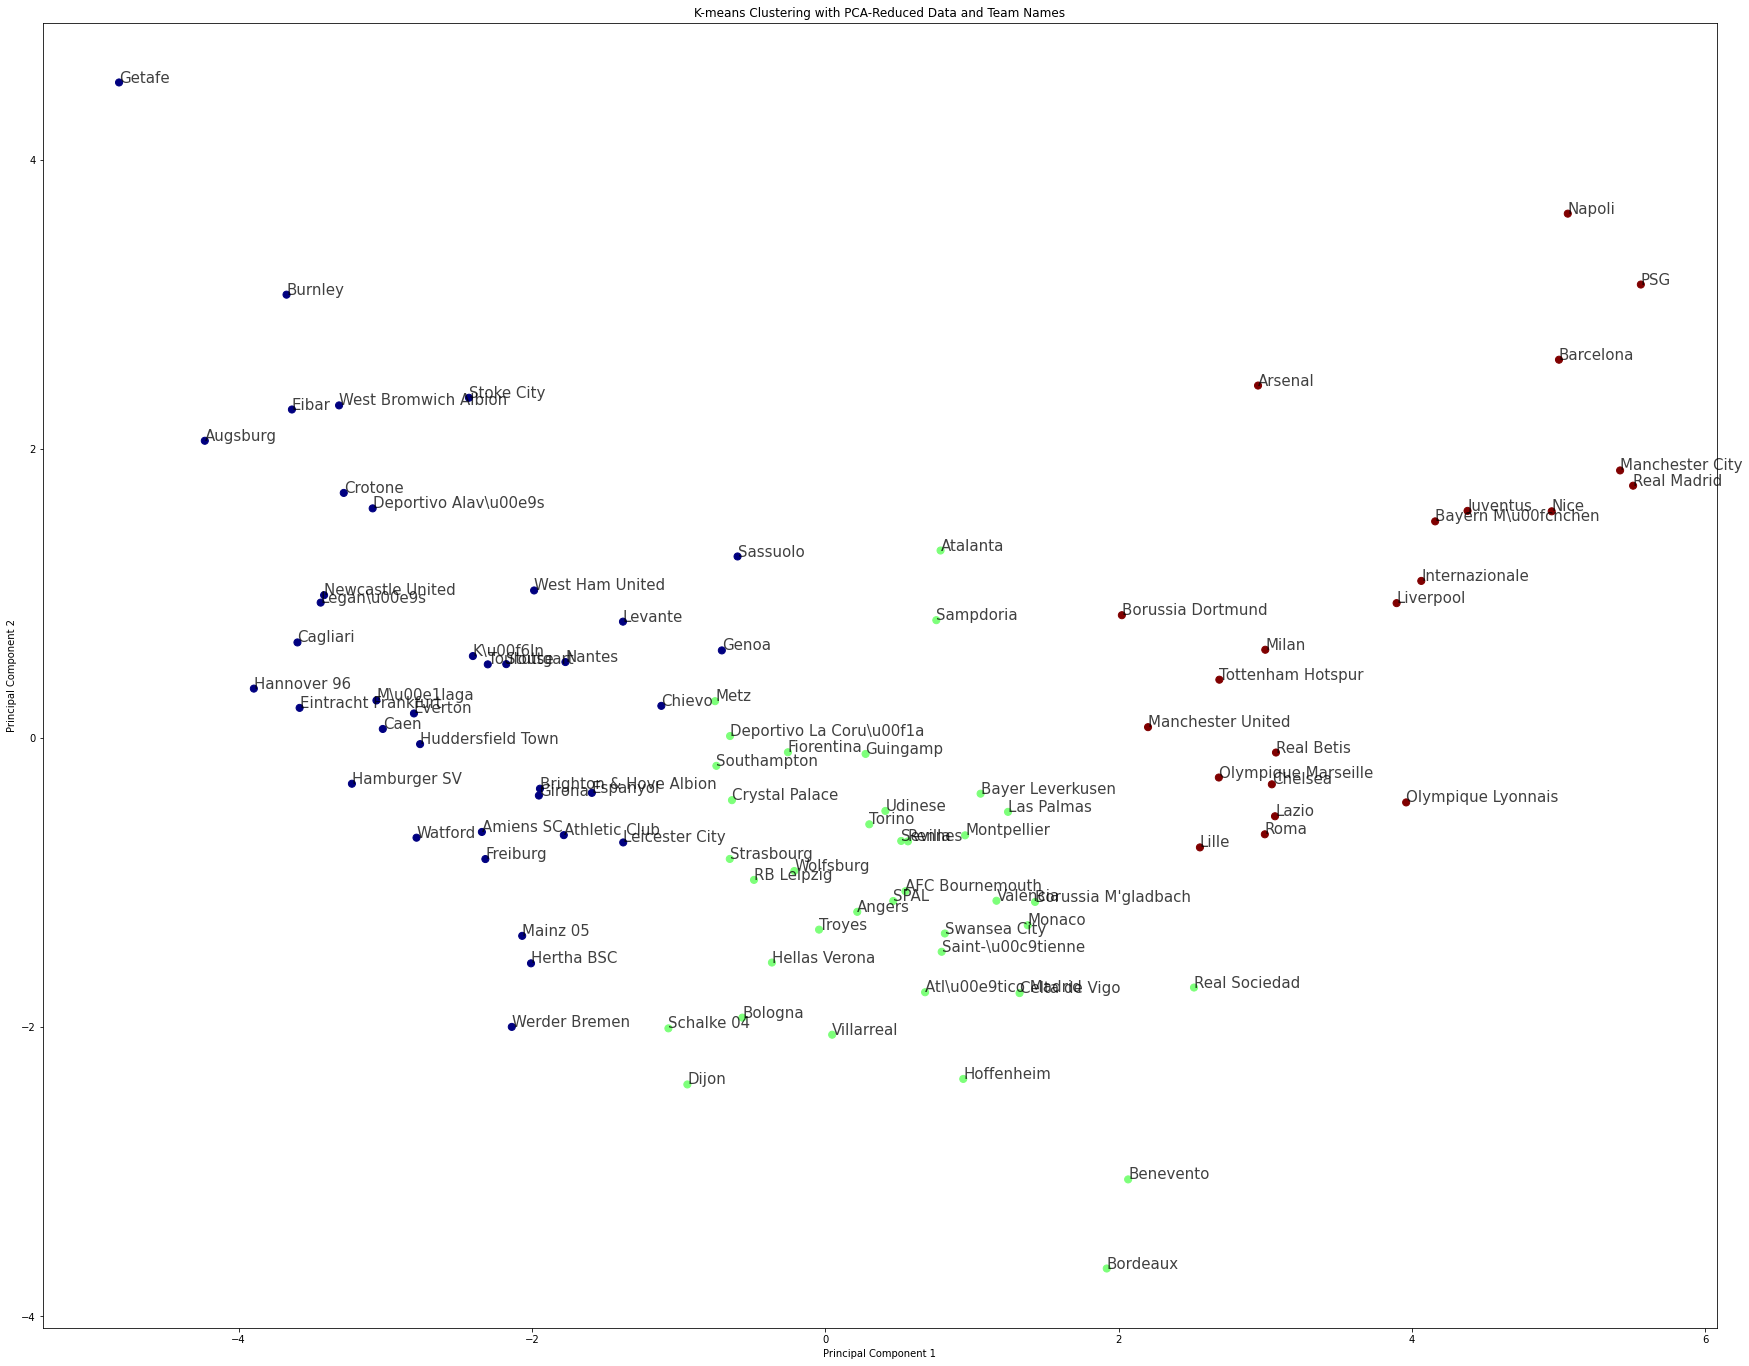

In [25]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(final_df_scaled)

# Create the scatter plot
plt.figure(figsize=(30, 24))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels, s=50, cmap='jet')

# Annotate each point with the team name
for i, team_name in enumerate(clustered_teams_with_names['name']):
    plt.annotate(team_name, (reduced_data[i, 0], reduced_data[i, 1]), fontsize=15, alpha=0.75)

# Adding title and labels
plt.title('K-means Clustering with PCA-Reduced Data and Team Names')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

In [26]:
df_with_clusters

,in_poss_cluster0,in_poss_cluster1,in_poss_cluster2,out_of_poss_cluster0,out_of_poss_cluster1,out_of_poss_cluster2,trans_out_of_poss_cluster0,trans_out_of_poss_cluster1,trans_out_of_poss_cluster2,trans_poss_cluster0,trans_poss_cluster1,trans_poss_cluster2,KMeans_Labels
0,0.421053,0.131579,0.447368,0.368421,0.289474,0.342105,0.526316,0.236842,0.236842,0.605263,0.052632,0.342105,1
1,0.868421,0.000000,0.131579,0.526316,0.473684,0.000000,0.526316,0.447368,0.026316,0.078947,0.000000,0.921053,2
2,0.868421,0.000000,0.131579,0.342105,0.631579,0.026316,0.605263,0.289474,0.105263,0.078947,0.000000,0.921053,2
3,0.210526,0.368421,0.421053,0.157895,0.473684,0.368421,0.473684,0.131579,0.394737,0.552632,0.263158,0.184211,1
4,0.105263,0.394737,0.500000,0.210526,0.315789,0.473684,0.368421,0.157895,0.473684,0.552632,0.368421,0.078947,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,0.131579,0.394737,0.473684,0.210526,0.394737,0.394737,0.552632,0.289474,0.157895,0.710526,0.157895,0.131579,1
94,0.184211,0.342105,0.473684,0.263158,0.447368,0.289474,0.447368,0.315789,0.236842,0.631579,0.236842,0.131579,1
95,0.078947,0.263158,0.657895,0.263158,0.315789,0.421053,0.315789,0.315789,0.368421,0.657895,0.263158,0.078947,1
96,0.184211,0.184211,0.631579,0.184211,0.578947,0.236842,0.657895,0.210526,0.131579,0.657895,0.236842,0.105263,1


In [27]:
# List of columns to include in the aggregation
cols_to_include = [col for col in df_with_clusters.columns if col != 'KMeans_Labels']

# Group by 'GMM_Labels' and calculate the mean and quantiles for each cluster
stats_per_cluster = df_with_clusters.groupby('KMeans_Labels')[cols_to_include].agg('mean')
# Renaming the lambda functions for clarity in the output
#stats_per_cluster.columns = stats_per_cluster.columns.map('_'.join).str.replace('<lambda_0>', '25th_percentile').str.replace('<lambda_1>', '50th_percentile (median)').str.replace('<lambda_2>', '75th_percentile')

stats_per_cluster

,in_poss_cluster0,in_poss_cluster1,in_poss_cluster2,out_of_poss_cluster0,out_of_poss_cluster1,out_of_poss_cluster2,trans_out_of_poss_cluster0,trans_out_of_poss_cluster1,trans_out_of_poss_cluster2,trans_poss_cluster0,trans_poss_cluster1,trans_poss_cluster2
KMeans_Labels,,,,,,,,,,,,
0,0.080618,0.560901,0.358481,0.133249,0.281204,0.585547,0.360192,0.152192,0.487616,0.462482,0.465659,0.071859
1,0.274116,0.222829,0.503055,0.263565,0.403699,0.332736,0.407161,0.277334,0.315504,0.551858,0.163150,0.284993
2,0.696032,0.035111,0.268857,0.370602,0.517520,0.111877,0.495708,0.335491,0.168801,0.254785,0.021953,0.723262


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

df = df_with_clusters

# Split the DataFrame into features (X) and the target variable (y)
X = df.drop('KMeans_Labels', axis=1)
y = df['KMeans_Labels']

# Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Dictionary to store the evaluation metrics of each model
evaluation_metrics = {}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    evaluation_metrics[name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

evaluation_metrics

{'Logistic Regression': {'Accuracy': 0.9,
  'Precision': 0.9125,
  'Recall': 0.9,
  'F1 Score': 0.9012987012987012},
 'Support Vector Machine': {'Accuracy': 0.9,
  'Precision': 0.9125,
  'Recall': 0.9,
  'F1 Score': 0.9012987012987012},
 'Random Forest': {'Accuracy': 0.9,
  'Precision': 0.9125,
  'Recall': 0.9,
  'F1 Score': 0.9012987012987012},
 'K-Nearest Neighbors': {'Accuracy': 0.9,
  'Precision': 0.9400000000000001,
  'Recall': 0.9,
  'F1 Score': 0.9075}}

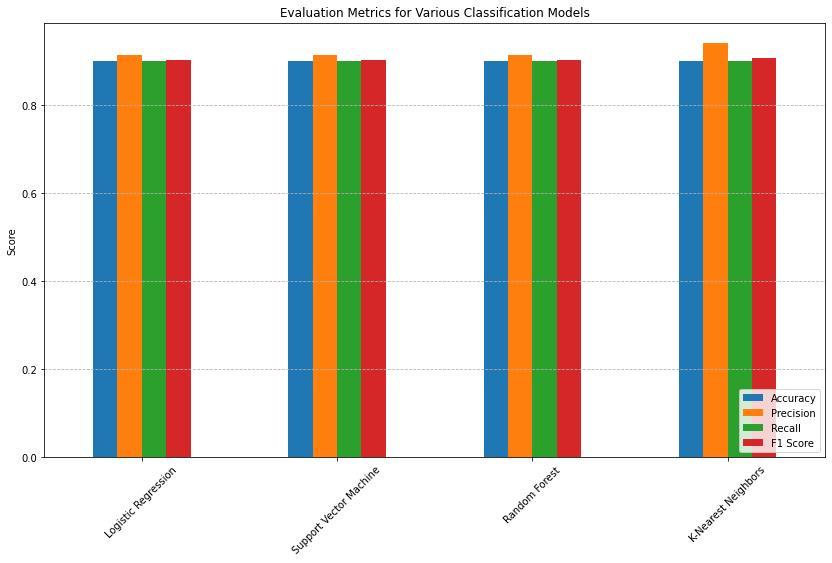

In [29]:
metrics_df = pd.DataFrame(evaluation_metrics).T

# Plotting
metrics_df.plot(kind='bar', figsize=(14, 8))
plt.title('Evaluation Metrics for Various Classification Models')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.legend(loc='lower right')
plt.show()


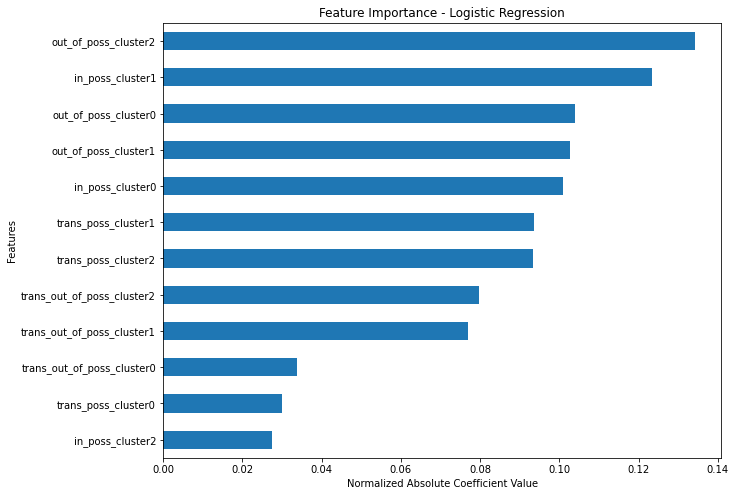

In [30]:
# Preprocessing steps
X = df.drop('KMeans_Labels', axis=1)
y = df['KMeans_Labels']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the Logistic Regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Extract the coefficients
coefficients = logistic_model.coef_[0]

# Take the absolute value of the coefficients and normalize
abs_coefficients = np.abs(coefficients)
normalized_coefficients = abs_coefficients / abs_coefficients.sum()

# Map normalized coefficients to feature names
feature_importance = pd.Series(normalized_coefficients, index=X.columns)

# Plotting the top 15 features
plt.figure(figsize=(10, 8))
feature_importance.sort_values().plot(kind='barh')
plt.title('Feature Importance - Logistic Regression')
plt.xlabel('Normalized Absolute Coefficient Value')
plt.ylabel('Features')
plt.show()